In [1]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Leer los datos en python

In [18]:
data = pd.read_csv('IMPORTACION.csv', sep=';')

data.head()
# Convertimos la columna 'FECHA' a datetime
# formato de fecha: 1/01/2000
# Solo cambia el mes y año
data['FECHA'] = pd.to_datetime(data['FECHA'], format='%d/%m/%Y')

# Convertimos los datos de la columna 'Superior' a flotantes
data['Superior'] = data['Superior'].str.replace(',', '').astype(float)
# Verificamos los primeros registros
data.head()

,FECHA,Aceites lubricantes,Asfalto,Bunker,Ceras,Combustible turbo jet,Diesel bajo azufre,Diesel ultra bajo azufre,Gas licuado de petr�leo,Gasolina de aviaci�n,...,Naftas,Petcoke,Petr�leo crudo,Solventes,Butano,Diesel alto azufre,MTBE,Orimulsi�n,Petr�leo reconstituido,Total importaci�n
0,2001-01-01,0,"27,748.99","214,581.84",0.0,0,0,0,"194,065.74",820,...,0.0,0,0,0,0.0,"566,101.99","8,402.00",0,"715,344.00","2,312,639.05"
1,2001-02-01,0,"7,503.57","294,609.00",0.0,0,0,0,"170,703.38","3,054.00",...,0.0,0,0,0,0.0,"489,525.80",0,0,"370,166.00","1,769,208.76"
2,2001-03-01,0,"26,304.32","315,263.80",0.0,0,0,0,"161,837.37",677,...,0.0,0,0,0,0.0,"575,559.68",0,0,"360,530.00","1,945,770.26"
3,2001-04-01,0,"7,885.89","205,653.00",0.0,0,0,0,"163,048.64","3,399.00",...,0.0,0,0,0,0.0,"437,745.42","8,184.00",0,"359,527.00","1,623,637.76"
4,2001-05-01,0,"8,443.16","278,371.30",0.0,0,0,0,"171,518.86",585,...,0.0,0,0,0,0.0,"552,609.13","12,680.00",0,"723,346.00","2,262,726.64"


In [19]:
# Dividimos los datos nuevamente en conjuntos de entrenamiento y prueba
train_data = data[data['FECHA'] <= '2021-12-01']['Superior']
test_data = data[(data['FECHA'] > '2021-12-01') & (data['FECHA'] <= '2023-06-30')]['Superior']
# Verificamos los datos de entrenamiento y prueba
train_data.tail(), test_data.head()

(247    685977.45
 248    646233.31
 249    589405.56
 250    623392.63
 251    640981.15
 Name: Superior, dtype: float64,
 252    947226.27
 253    673653.80
 254    592318.21
 255    493958.32
 256    663348.94
 Name: Superior, dtype: float64)

## Normalizamos el precio del combustible

In [20]:


# Función para convertir la serie de tiempo en secuencias de entrada y salida
def create_sequences(data, seq_length):
    sequences = []
    target = []
    for i in range(len(data) - seq_length):
        seq = data[i : i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        target.append(label)
    return np.array(sequences), np.array(target)

# Normalizamos los datos utilizando MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data.values.reshape(-1, 1))

# Creamos secuencias para los datos de entrenamiento
seq_length = 10
X_train, y_train = create_sequences(scaled_train_data, seq_length)

# Verificamos las dimensiones de las secuencias creadas
X_train.shape, y_train.shape


((242, 10, 1), (242, 1))

## Definicion De modelo

In [8]:

# Definición de la arquitectura de la red neuronal
class TimeSeriesPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_length, num_layers=2):
        super(TimeSeriesPredictor, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.seq_length = seq_length
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
        )
        self.linear = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        lstm_out, _ = self.lstm(x, (h_0, c_0))
        lstm_out = lstm_out[:, -1, :]
        output = self.linear(lstm_out)

        return output

# Parámetros
input_dim = 1
hidden_dim = 50
num_layers = 2

# Instanciamos el modelo
model = TimeSeriesPredictor(input_dim, hidden_dim, seq_length, num_layers)

# Verificamos la arquitectura de la red
model


TimeSeriesPredictor(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True)
  (linear): Linear(in_features=50, out_features=1, bias=True)
)

## Entrenamiento del primer Modelo

In [9]:

# Hiperparámetros
batch_size = 32
epochs = 100
learning_rate = 0.001

# Convertimos los datos a tensores de PyTorch
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# Función de pérdida y optimizador
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Entrenamiento
model.train()
for epoch in range(epochs):
    for batch_X, batch_y in train_loader:
        # Forward pass
        predictions = model(batch_X)
        loss = loss_function(predictions, batch_y)

        # Backward pass y optimización
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Imprimimos el progreso
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.4f}")

print("Entrenamiento completado.")


Epoch [10/100], Loss: 0.0372
Epoch [20/100], Loss: 0.0094
Epoch [30/100], Loss: 0.0154
Epoch [40/100], Loss: 0.0108
Epoch [50/100], Loss: 0.0294
Epoch [60/100], Loss: 0.0091
Epoch [70/100], Loss: 0.0148
Epoch [80/100], Loss: 0.0103
Epoch [90/100], Loss: 0.0220
Epoch [100/100], Loss: 0.0097
Entrenamiento completado.


In [10]:
# Normalizamos y creamos secuencias para los datos de prueba
scaled_test_data = scaler.transform(test_data.values.reshape(-1, 1))
X_test, y_test = create_sequences(scaled_test_data, seq_length)

# Convertimos los datos de prueba a tensores de PyTorch
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Evaluación del modelo en los datos de prueba
model.eval()
test_loss = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        predictions = model(batch_X)
        loss = loss_function(predictions, batch_y)
        test_loss += loss.item()

# Calculamos la pérdida promedio en los datos de prueba
test_loss /= len(test_loader)
test_loss


0.004550616256892681

## Predicciones del Primero Modelo

In [11]:
# Función para convertir la serie de tiempo en secuencias de entrada y salida
def create_sequences(data, seq_length):
    sequences = []
    target = []
    for i in range(len(data) - seq_length):
        seq = data[i : i + seq_length]
        label = data[i + seq_length]
        sequences.append(seq)
        target.append(label)
    return np.array(sequences), np.array(target)

# Ajustamos la longitud de la secuencia a 12 (para tener en cuenta los 12 meses del año)
seq_length = 12
X_train, y_train = create_sequences(scaled_train_data, seq_length)

# Ajustamos la función para predecir el futuro
def predict_future(model, last_sequence, future_steps):
    future_predictions = []
    current_sequence = last_sequence.clone().detach()
    
    model.eval()
    with torch.no_grad():
        for i in range(future_steps):
            prediction = model(current_sequence)
            future_predictions.append(prediction.item())
            # Creamos una copia de la secuencia actual antes de actualizarla
            new_sequence = current_sequence.clone()
            new_sequence[0, :-1, 0] = current_sequence[0, 1:, 0]
            new_sequence[0, -1, 0] = prediction
            current_sequence = new_sequence
        
    return future_predictions

# Ajustamos la función para predecir cada año
def predict_year(model, start_sequence, num_months=12):
    predictions = []

    # Por cada mes
    for _ in range(num_months):
        # Predecimos el siguiente mes (no 30 días)
        future_predictions_scaled = predict_future(model, start_sequence, future_steps=1)
        future_predictions = scaler.inverse_transform(np.array(future_predictions_scaled).reshape(-1, 1))
        
        # Agregamos las predicciones a la lista de resultados
        predictions.append(future_predictions)
        
        # Actualizamos la secuencia inicial con las predicciones del último mes
        new_sequence_scaled = np.concatenate([start_sequence[0, 1:, 0].numpy(), future_predictions_scaled])
        start_sequence = torch.tensor(new_sequence_scaled.reshape(1, seq_length, 1), dtype=torch.float32)

    # Concatenamos todas las predicciones
    predictions = np.concatenate(predictions)
    
    return predictions

def update_last_sequence(last_sequence, new_predictions, seq_length):
    new_sequence = np.concatenate([last_sequence[0, 1:, 0].numpy(), new_predictions[-1:].flatten()])
    return torch.tensor(new_sequence.reshape(1, seq_length, 1), dtype=torch.float32)

# Ajustamos la última secuencia disponible en los datos (hasta diciembre de 2019)
last_sequence = torch.tensor(scaled_train_data[-seq_length:].reshape(1, seq_length, 1), dtype=torch.float32)

# Predecimos cada año

predictions_2021 = predict_year(model, last_sequence)
last_sequence = update_last_sequence(last_sequence, predictions_2021, seq_length)

predictions_2022 = predict_year(model, last_sequence)
last_sequence = update_last_sequence(last_sequence, predictions_2022, seq_length)

predictions_2023 = predict_year(model, last_sequence)

predictions = np.concatenate([predictions_2021, predictions_2022, predictions_2023])
print(predictions)

[[ 650501.60363308]
 [ 648976.68322357]
 [ 647439.69926804]
 [ 644190.10124578]
 [ 635170.82098917]
 [ 634317.45897292]
 [ 633340.81570572]
 [ 631238.35696786]
 [ 629323.37140464]
 [ 628169.80662838]
 [ 627949.85952177]
 [ 627205.32139973]
 [1309007.96454467]
 [1394658.25933167]
 [1291955.71703396]
 [1171470.1220175 ]
 [1065357.02942562]
 [ 981635.57910588]
 [ 918186.11468041]
 [ 870848.19315644]
 [ 835726.70655855]
 [ 809605.19224415]
 [ 789985.393775  ]
 [ 774936.19886317]
 [1584653.62852517]
 [1575918.99125903]
 [1464832.56795743]
 [1333729.47757098]
 [1204488.45693232]
 [1092413.83077765]
 [1002101.77864176]
 [ 932415.74440333]
 [ 880053.02523964]
 [ 841304.60045951]
 [ 812786.94463163]
 [ 793020.49375973]]


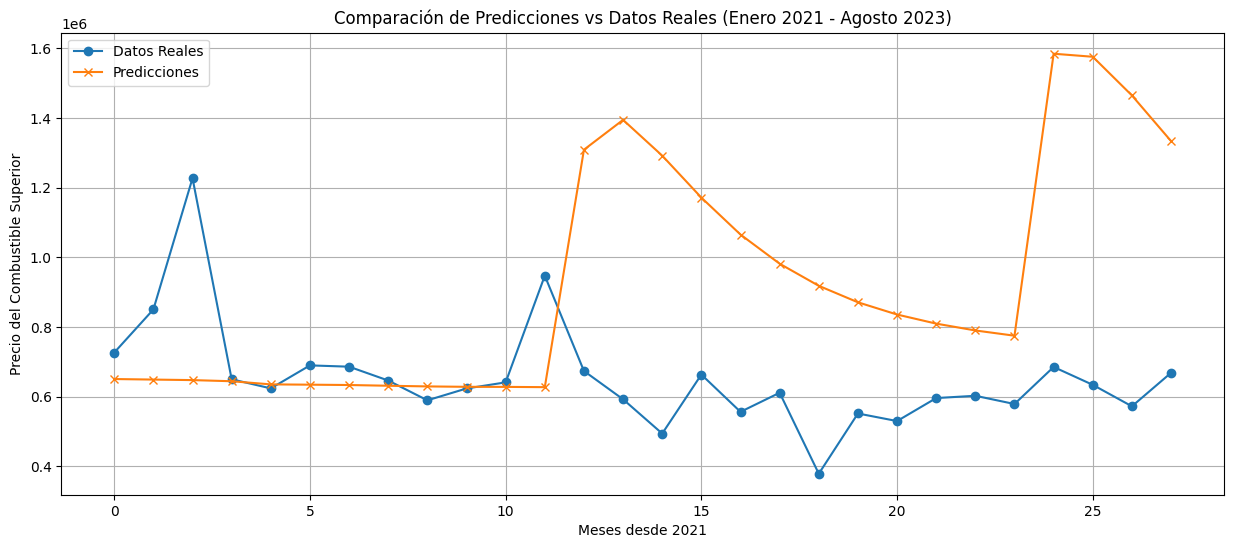

In [22]:


# Extraemos los datos reales para junio, julio y principios de agosto
real_data_june_july_august = data[(data['FECHA'] > '2021-01-01') & (data['FECHA'] <= '2023-08-31')]['Superior'].values

# Concatenamos las predicciones para estos meses
predicted_data_june_july_august = predictions

# Truncamos las predicciones para que coincidan con la longitud de los datos reales (si es necesario)
predicted_data_june_july_august = predicted_data_june_july_august[:len(real_data_june_july_august)]

# Gráfica comparando las predicciones con los datos reales
plt.figure(figsize=(15, 6))
plt.plot(real_data_june_july_august, label='Datos Reales', marker='o')
plt.plot(predicted_data_june_july_august, label='Predicciones', marker='x')
plt.xlabel('Meses desde 2021')
plt.ylabel('Precio del Combustible Superior')
plt.title('Comparación de Predicciones vs Datos Reales (Enero 2021 - Agosto 2023)')
plt.legend()
plt.grid(True)
plt.show()


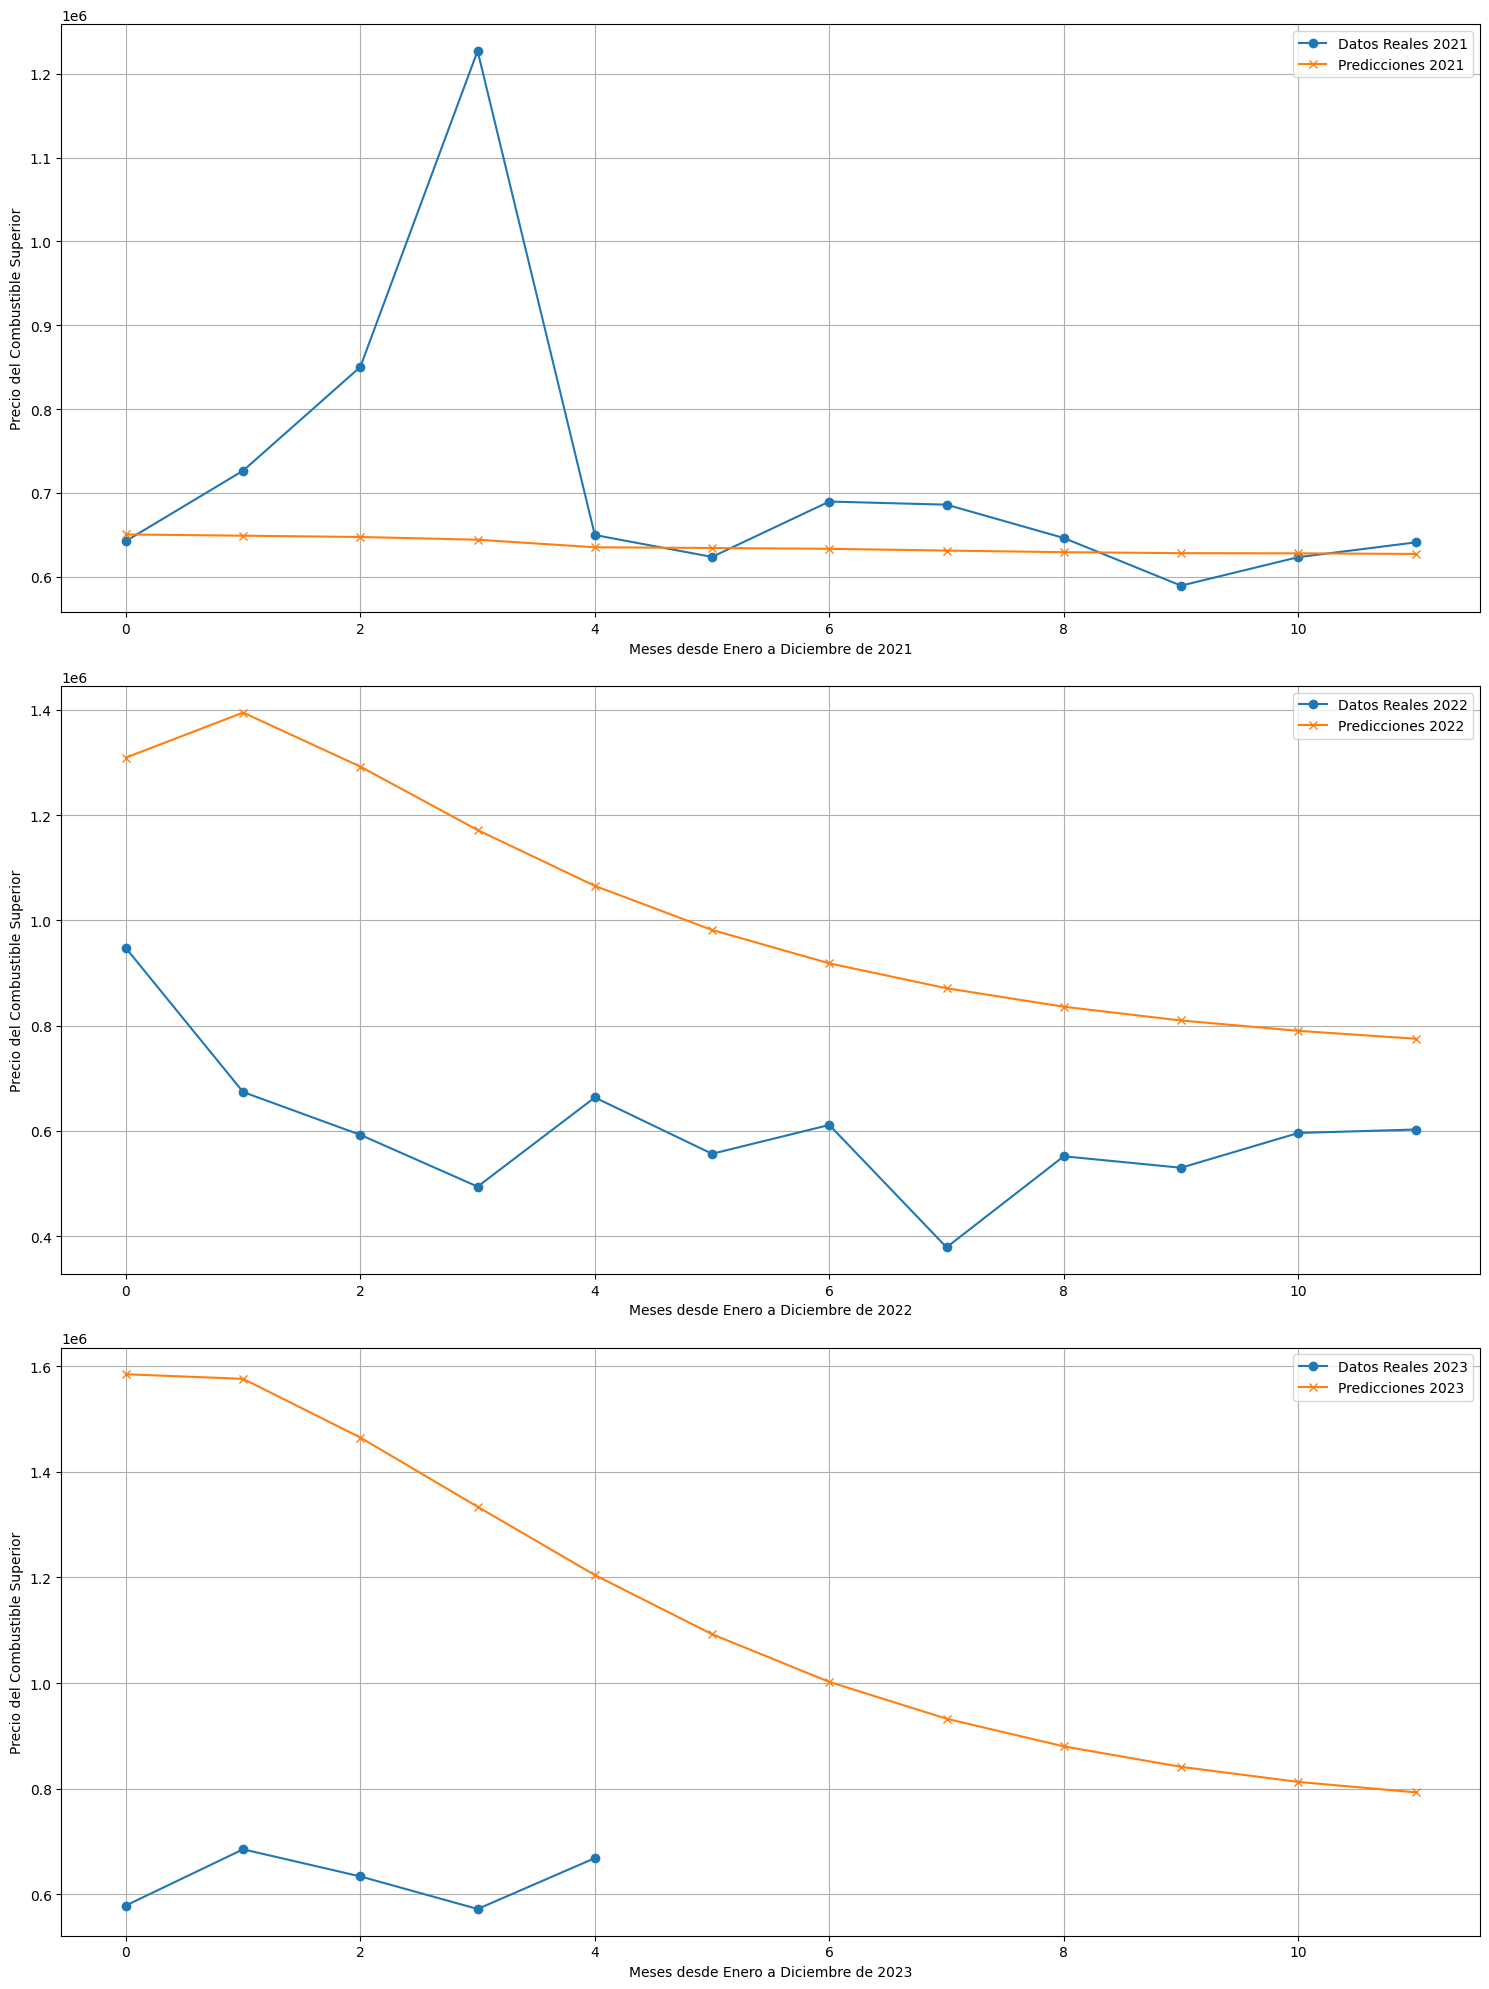

In [23]:
import matplotlib.pyplot as plt


real_data_2021 = data[(data['FECHA'] >= '2021-01-01') & (data['FECHA'] < '2022-01-01')]['Superior'].values
real_data_2022 = data[(data['FECHA'] >= '2022-01-01') & (data['FECHA'] < '2023-01-01')]['Superior'].values
real_data_2023 = data[(data['FECHA'] >= '2023-01-01') & (data['FECHA'] < '2024-01-01')]['Superior'].values

# Creamos una figura para trazar las predicciones de cada año
fig, axs = plt.subplots(3, figsize=(15, 20))

# 2021
axs[0].plot(real_data_2021, label='Datos Reales 2021', marker='o')
axs[0].plot(predictions_2021, label='Predicciones 2021', marker='x')
axs[0].set_xlabel('Meses desde Enero a Diciembre de 2021')
axs[0].set_ylabel('Precio del Combustible Superior')
axs[0].legend()
axs[0].grid(True)

# 2022
axs[1].plot(real_data_2022, label='Datos Reales 2022', marker='o')
axs[1].plot(predictions_2022, label='Predicciones 2022', marker='x')
axs[1].set_xlabel('Meses desde Enero a Diciembre de 2022')
axs[1].set_ylabel('Precio del Combustible Superior')
axs[1].legend()
axs[1].grid(True)

# 2023
axs[2].plot(real_data_2023, label='Datos Reales 2023', marker='o')
axs[2].plot(predictions_2023, label='Predicciones 2023', marker='x')
axs[2].set_xlabel('Meses desde Enero a Diciembre de 2023')
axs[2].set_ylabel('Precio del Combustible Superior')
axs[2].legend()
axs[2].grid(True)

# Mostramos la figura
plt.tight_layout()
plt.show()


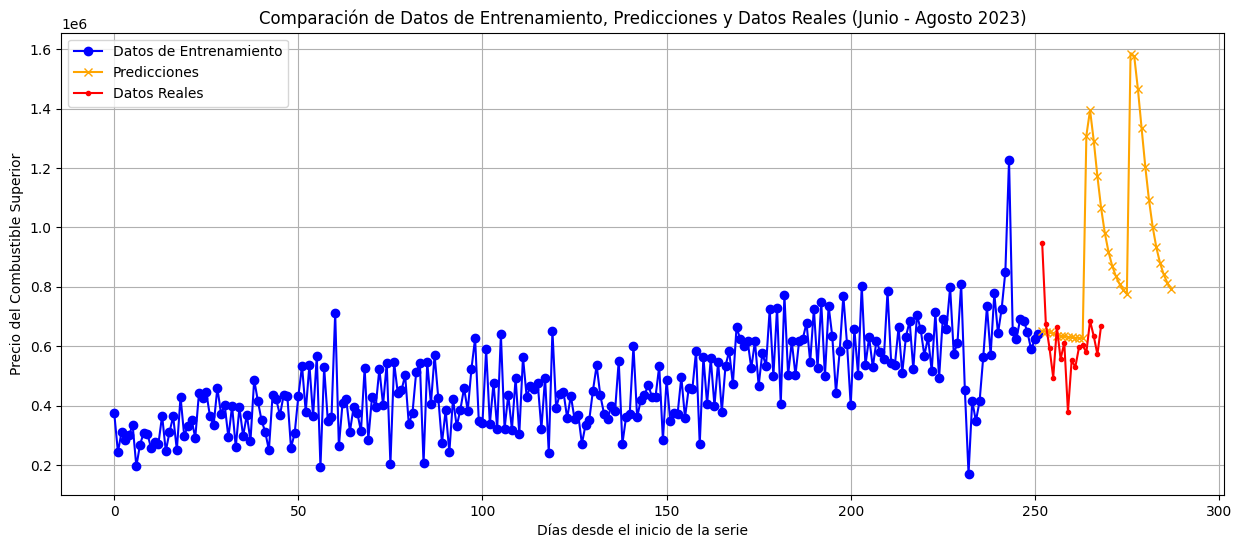

In [17]:

train_data_visualization = train_data.values
real_data = test_data.values

# Aseguramos que todas las secuencias tengan la misma longitud
min_length = min(len(train_data_visualization), len(real_data), len(predictions))

# Gráfica comparando los datos de entrenamiento, predicciones y datos reales
plt.figure(figsize=(15, 6))
plt.plot(train_data_visualization, label='Datos de Entrenamiento', marker='o', color='blue')
plt.plot(range(len(train_data_visualization), len(train_data_visualization) + len(predictions)), 
         predictions, label='Predicciones', marker='x', color='orange')
plt.plot(range(len(train_data_visualization), len(train_data_visualization) + len(real_data)), 
         real_data, label='Datos Reales', marker='.', color='red')
plt.xlabel('Días desde el inicio de la serie')
plt.ylabel('Precio del Combustible Superior')
plt.title('Comparación de Datos de Entrenamiento, Predicciones y Datos Reales (Junio - Agosto 2023)')
plt.legend()
plt.grid(True)
plt.show()

In [24]:


# Calculamos el MSE y RMSE
mse = mean_squared_error(real_data_june_july_august, predicted_data_june_july_august[:len(real_data_june_july_august)])
rmse = mean_squared_error(real_data_june_july_august, predicted_data_june_july_august[:len(real_data_june_july_august)], squared=False)

# Calculamos el coeficiente de determinación (R^2)
r2 = r2_score(real_data_june_july_august, predicted_data_june_july_august[:len(real_data_june_july_august)])

mse, rmse, r2


(227624944806.52563, 477100.5604760129, -9.11911638874049)

Aunque el modelo no logra ajustarse bien a los datos, al inicio del 2021 